In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [2]:
SHOTS=1000
N_QUBITS = 3
QUBITS_RANGE = list(range(3))

In [3]:
def get_theta(prob):
    """
        Returns a theta angle which puts |1> in the desired probability
    """
    assert prob <= 1 and prob >= 0, "Invalid probability"
    return 2 * np.arcsin(np.sqrt(prob))

In [4]:
def draw_circuit(circuit, *args, filename=None):
    qml.draw_mpl(circuit)(*args)
    if(filename):
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [5]:
def plot(df, title, filename=None):
    labels = df['labels']
    data = df['values']
    
    plt.grid(color='gray', linestyle='--', linewidth=0.4)
    plt.bar(labels, data)
    plt.title(title)
    plt.ylabel("Results")
    plt.xticks(rotation=50)

    if(filename):
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

In [6]:
device = qml.device("lightning.qubit", wires=N_QUBITS, shots=SHOTS)

| qubit | Meaning                      |
|-------|----------------------------------|
|   0   | positive(1) negative(0) |
|   1   | false psotive/negative |
|   2   | chance of having the disease |


| odds | to |
|---------------|-------|
|  0.2          | false positive |
|  0.4         | false negative |
|  0.01         | have the disease given a false positive/negative |

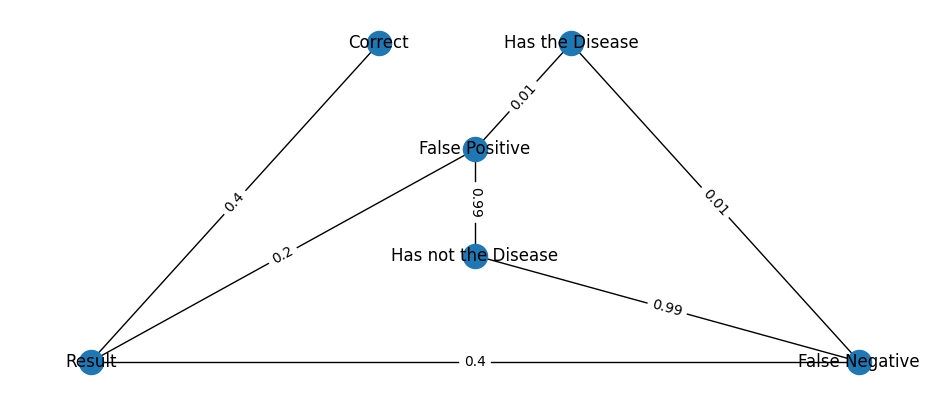

In [7]:
G = nx.Graph()
G.add_node("Result")
G.add_node("False Positive")
G.add_node("False Negative")

G.add_edge("Result", "False Positive", weight=0.2)
G.add_edge("Result", "False Negative", weight=0.4)
G.add_edge("Result", "Correct", weight=0.4)

G.add_edge("False Positive", "Has the Disease", weight=0.01)
G.add_edge("False Positive", "Has not the Disease", weight=0.99)

G.add_edge("False Negative", "Has the Disease", weight=0.01)
G.add_edge("False Negative", "Has not the Disease", weight=0.99)

plt.figure(figsize=(12,5))

pos = nx.planar_layout(G)
nx.draw_networkx(G,pos)

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.savefig("assets/probabilities_graph.png", bbox_inches='tight')
plt.show()

In [8]:
PROB_FALSE_POSITIVE = 0.2
PROB_FALSE_NEGATIVE = 0.4
PROB_DISEASE_WRONG_TEST = 0.01

@qml.qnode(device)
def circuit(status=False):
    if(status):
        qml.X(wires=[0])
        
    qml.Barrier(only_visual=True, wires=QUBITS_RANGE)

    qml.CRY(get_theta(PROB_FALSE_POSITIVE), wires=[0, 1])
    
    qml.X(wires=[0])
    qml.CRY(get_theta(PROB_FALSE_NEGATIVE), wires=[0, 1])
    qml.X(wires=[0])
    
    qml.Barrier(only_visual=True, wires=QUBITS_RANGE)
    
    qml.CRY(get_theta(PROB_DISEASE_WRONG_TEST), wires=[1,2])

    qml.X(wires=[1])
    qml.Toffoli(wires=[0,1,2])
    qml.X(wires=[1])
    
    qml.Barrier(only_visual=True, wires=QUBITS_RANGE)

    return qml.probs(wires=[1,2])
    

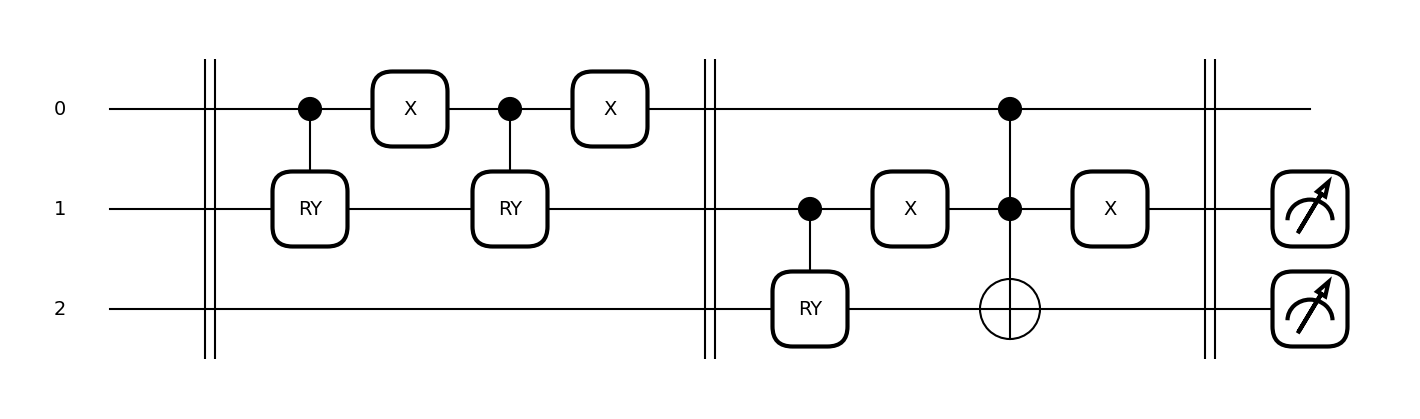

In [9]:
draw_circuit(circuit,filename="assets/first_example.png")

In [10]:
idx = ['00', '01', '10', '11']
labels = ['correct without the disease', 'correct with the disease', 'wrong without the disease', 'wrong with the disease']
get_df = lambda data: pd.DataFrame({"values": data, "labels":labels}, columns=["values", "labels"], index=idx)

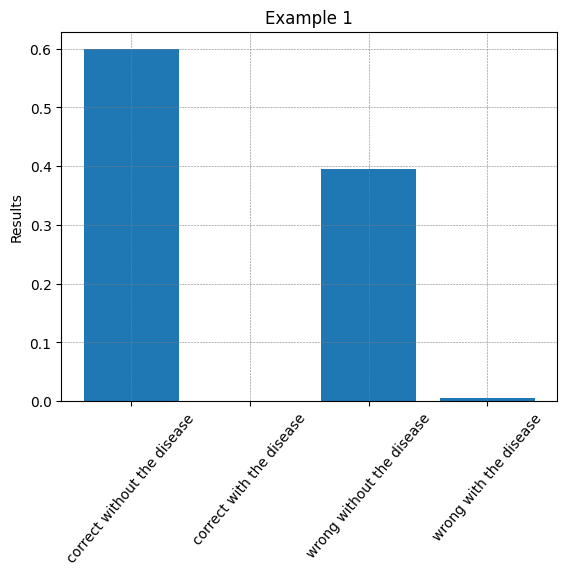

In [11]:
probs = circuit()
df = get_df(probs)
plot(df, "Example 1", filename="assets/probs_example_1.png")

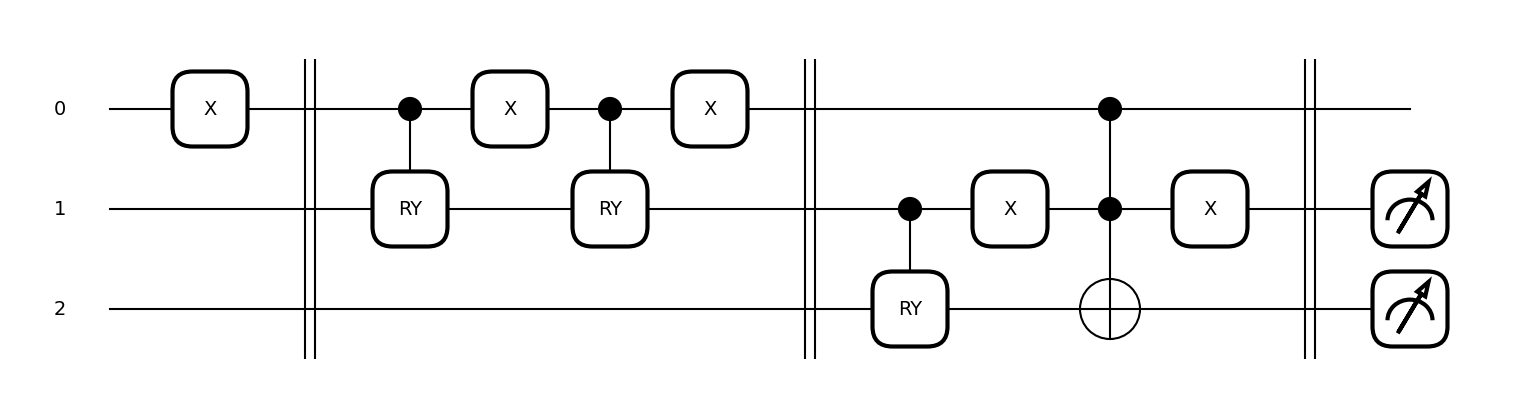

In [12]:
draw_circuit(circuit, True, filename="assets/circuit_example_2.png")

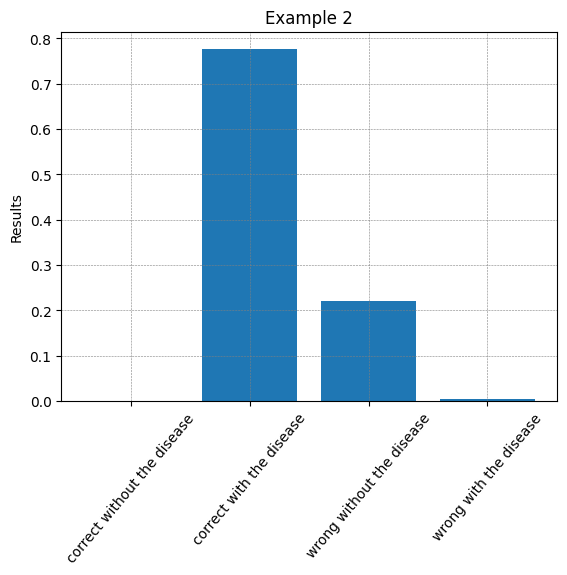

In [13]:
probs = circuit(True)
df = get_df(probs)
plot(df, "Example 2", filename="assets/probs_example_2.png")